In [18]:
import os
os.environ["KERAS_BACKEND"] = "torch"
# ensure the backend is set
import argparse
import torch
import keras
from torch.utils.data import DataLoader
import numpy as np
import optuna
from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend

In [2]:

import bayesflow as bf
from dl_src.load_data import data_loader
from keras.src.backend.common import global_state
global_state.set_global_attribute("torch_device", "cpu")

In [3]:
%load_ext autoreload
%autoreload 2

In [37]:
train_dataset, val_dataset, inference_variables = data_loader()


In [38]:
study_name = "study_rmse_calerror"  # Unique identifier of the study.

storage = JournalStorage(JournalFileBackend(f"{study_name}.log"))


study = optuna.load_study(study_name=study_name, storage=storage)

In [39]:
study.best_trials

[FrozenTrial(number=44, state=1, values=[0.187490776181221, 0.05718319632753282], datetime_start=datetime.datetime(2025, 1, 27, 3, 1, 46, 898757), datetime_complete=datetime.datetime(2025, 1, 27, 3, 6, 28, 868848), params={'summary_dim': 190, 'num_blocks': 1, 'num_heads': 5, 'embed_dims': 37, 'mlp_depths': 2, 'mlp_widths': 84, 'mlp_dropout': 0.3490192617692009, 'time_embedding': 'gru', 'time_embed_dim': 11, 'width': 180, 'depth': 4, 'dropout': 0.43636959032798417, 'lr': 0.00046122372431394365, 'residual': False}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'summary_dim': IntDistribution(high=256, log=False, low=32, step=1), 'num_blocks': IntDistribution(high=4, log=False, low=1, step=1), 'num_heads': IntDistribution(high=8, log=False, low=4, step=1), 'embed_dims': IntDistribution(high=128, log=False, low=8, step=1), 'mlp_depths': IntDistribution(high=4, log=False, low=1, step=1), 'mlp_widths': IntDistribution(high=256, log=False, low=16, 

In [40]:
def get_model_objective(trial, epochs=75):

		summary_dim = trial.suggest_int("summary_dim", 32, 256)
		num_blocks = trial.suggest_int("num_blocks", 1, 4)
		num_heads = (trial.suggest_int("num_heads", 4, 8),) * num_blocks
		embed_dims = (trial.suggest_int("embed_dims", 8, 128),) * num_blocks
		mlp_depths = (trial.suggest_int("mlp_depths", 1, 4),) * num_blocks
		mlp_widths = (trial.suggest_int("mlp_widths", 16, 256),) * num_blocks
		summary_dropout = trial.suggest_float("mlp_dropout", 0.01, 0.5)
		time_embedding = trial.suggest_categorical("time_embedding", ["time2vec", "lstm", "gru"])
		time_embed_dim = trial.suggest_int("time_embed_dim", 8,32)

		summary_net = bf.networks.TimeSeriesTransformer(
			summary_dim=summary_dim,
			embed_dims=embed_dims,
			num_heads=num_heads,
			mlp_depths=mlp_depths,
			mlp_widths=mlp_widths,
			dropout=summary_dropout,
			time_axis=-1,
			time_embedding=time_embedding,
			time_embed_dim=time_embed_dim
		)
		
		# Optimize hyperparameters
		inf_width = trial.suggest_int("width", 128, 512)
		inf_depth = trial.suggest_int("depth", 2, 8)
		inf_dropout = trial.suggest_float("dropout", 0.01, 0.5)
		initial_learning_rate = trial.suggest_float("lr", 1e-4, 1e-3)
		residual = trial.suggest_categorical("residual", [True, False])
		# spectral_normalization = trial.suggest_categorical("spectral_normalization", [True, False])
		
		# Create inference net
		sigma2 = 1
		inference_network = bf.networks.ContinuousConsistencyModel(
				subnet_kwargs={
					"widths": (inf_width,)*inf_depth,
				 "dropout": inf_dropout, 
				 "residual": residual
				#  "spectral_normalization": spectral_normalization
				},
				sigma_data=sigma2
		)
		
		# Create optimizer
		scheduled_lr = keras.optimizers.schedules.CosineDecay(
				initial_learning_rate=initial_learning_rate,
				decay_steps=epochs*train_dataset.num_batches,
				alpha=1e-8
		)
		optimizer = keras.optimizers.Adam(learning_rate=scheduled_lr)
		
		
		# Create approximator
		approximator = bf.ContinuousApproximator(
			summary_network=summary_net,
			inference_network=inference_network,
			adapter=None
		)
		approximator.compile(optimizer=optimizer)
		
		# Train and compute the average of last 10 validation losses
		history = approximator.fit(
				epochs=epochs,
				dataset=train_dataset,
				validation_data=val_dataset,
				verbose=1,
				callbacks=[keras.callbacks.EarlyStopping(patience=10,monitor="val_loss")]
				# callbacks=[KerasPruningCallback(trial, "val_loss", interval=10)]
		)

		return history, approximator

In [41]:
history, approximator = get_model_objective(study.best_trials[1])

INFO:bayesflow:Fitting on dataset instance of OfflineQSPDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/75
247/247 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - loss: -2.0981 - loss/inference_loss: -2.0981 - val_loss: -2.9708 - val_loss/inference_loss: -2.9708
Epoch 2/75
247/247 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: -2.8522 - loss/inference_loss: -2.8522 - val_loss: -2.9792 - val_loss/inference_loss: -2.9792
Epoch 3/75
247/247 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - loss: -2.8848 - loss/inference_loss: -2.8848 - val_loss: -2.9839 - val_loss/inference_loss: -2.9839
Epoch 4/75
247/247 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - loss: -2.8499 - loss/inference_loss: -2.8499 - val_loss: -3.0459 - val_loss/inference_loss: -3.0459
Epoch 5/75
247/247 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - loss: -2.9063 - loss/inference_loss: -2.9063 - val_loss: -3.0641 - val_loss/inference_loss: -3.0641
Epoch 6/75
247/247 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - loss: -2.8805 - loss/inference_loss: -2.8805 - val_loss: -2.9937 - val_loss/inference_loss: -2.9937
Epoch 7/75
247/247 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - loss: -2

In [42]:
# summary_dim = 64 # boundary
# num_blocks = 3 
# num_heads = (6,) * num_blocks # boundary
# embed_dims = (26,) * num_blocks
# mlp_depths = (2,) * num_blocks
# mlp_widths = (64,) * num_blocks
# summary_dropout = 0.09
# time_embedding = "time2vec"
# time_embed_dim = 16 # boundary


# summary_net = bf.networks.TimeSeriesTransformer(
# 		summary_dim=summary_dim,
# 		embed_dims=embed_dims,
# 		num_heads=num_heads,
# 		mlp_depths=mlp_depths,
# 		mlp_widths=mlp_widths,
# 		dropout=summary_dropout,
# 		time_axis=-1,
# 		time_embedding=time_embedding,
# 		time_embed_dim=time_embed_dim
# 	)

# # Optimize hyperparameters
# inf_width = 477 # boundary
# inf_depth = 2 # left boundary
# inf_dropout = 0.04 # left boundary
# initial_learning_rate = 3.6e-4
# residual = True
# # spectral_normalization = trial.suggest_categorical("spectral_normalization", [True, False])

# # Create inference net
# sigma2 = 1
# inference_network = bf.networks.ContinuousConsistencyModel(
# 		subnet_kwargs={
# 			"widths": (inf_width,)*inf_depth,
# 			"dropout": inf_dropout, 
# 			"residual": residual
# 		#  "spectral_normalization": spectral_normalization
# 		},
# 		sigma_data=sigma2
# )

# # Create optimizer
# scheduled_lr = keras.optimizers.schedules.CosineDecay(
# 		initial_learning_rate=initial_learning_rate,
# 		decay_steps=epochs*train_dataset.num_batches,
# 		alpha=1e-8
# )
# optimizer = keras.optimizers.Adam(learning_rate=scheduled_lr)


# # Create approximator
# approximator = bf.ContinuousApproximator(
# 	summary_network=summary_net,
# 	inference_network=inference_network,
# 	adapter=None
# )
# approximator.compile(optimizer=optimizer)

In [43]:

# Train and compute the average of last 10 validation losses
# history = approximator.fit(
# 		epochs=epochs,
# 		dataset=train_dataset,
# 		validation_data=val_dataset,
# 		verbose=1,
# 		# callbacks=[keras.callbacks.EarlyStopping(patience=5,monitor="val_loss")]
# 		# callbacks=[KerasPruningCallback(trial, "val_loss", interval=10)]
# )


In [44]:
summaries = []
references = []
for i in range(val_dataset.num_batches):
	batch = val_dataset[i]
	summaries.append(batch["summary_variables"])
	references.append(batch["inference_variables"])

summaries = torch.cat(summaries, dim=0)
references = torch.cat(references, dim=0)

targets = approximator._sample(num_samples=500,summary_variables=summaries)

cal_dict = bf.diagnostics.metrics.calibration_error(targets.numpy(),references.numpy())

In [45]:
bf.diagnostics.metrics.root_mean_squared_error(targets.numpy(), references.numpy())

{'values': array([0.2510314 , 0.2656901 , 0.24873964, 0.23823023, 0.10053495,
        0.06955096, 0.31045532], dtype=float32),
 'metric_name': 'NRMSE',
 'variable_names': ['$var_{0}$',
  '$var_{1}$',
  '$var_{2}$',
  '$var_{3}$',
  '$var_{4}$',
  '$var_{5}$',
  '$var_{6}$']}

IndexError: index 7 is out of bounds for axis 1 with size 7

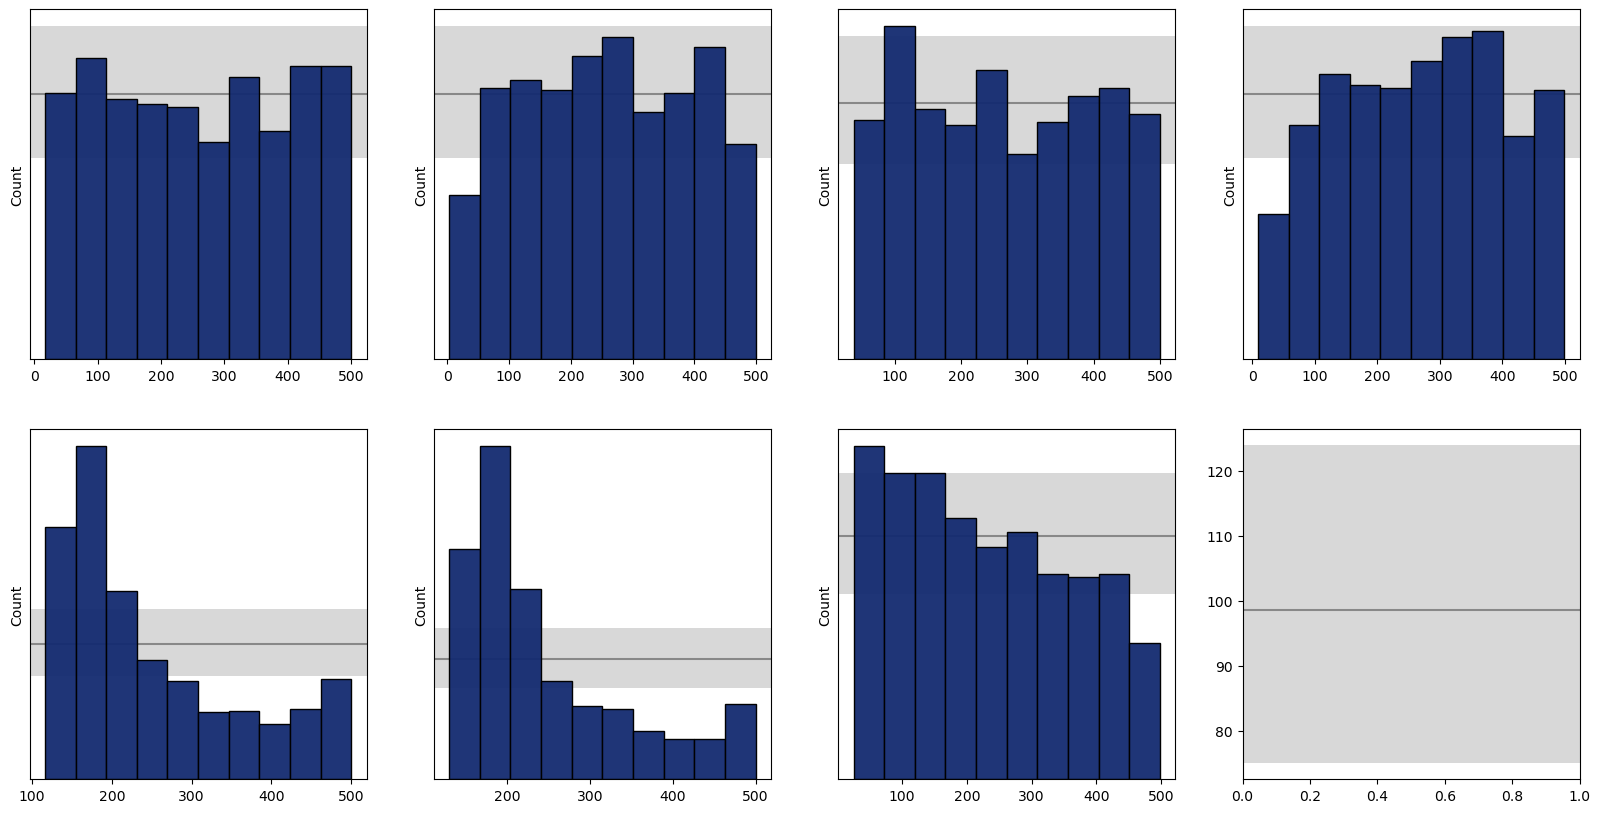

In [46]:
f = bf.diagnostics.plots.calibration_histogram(targets.numpy(),references.numpy(),variable_names=inference_variables)

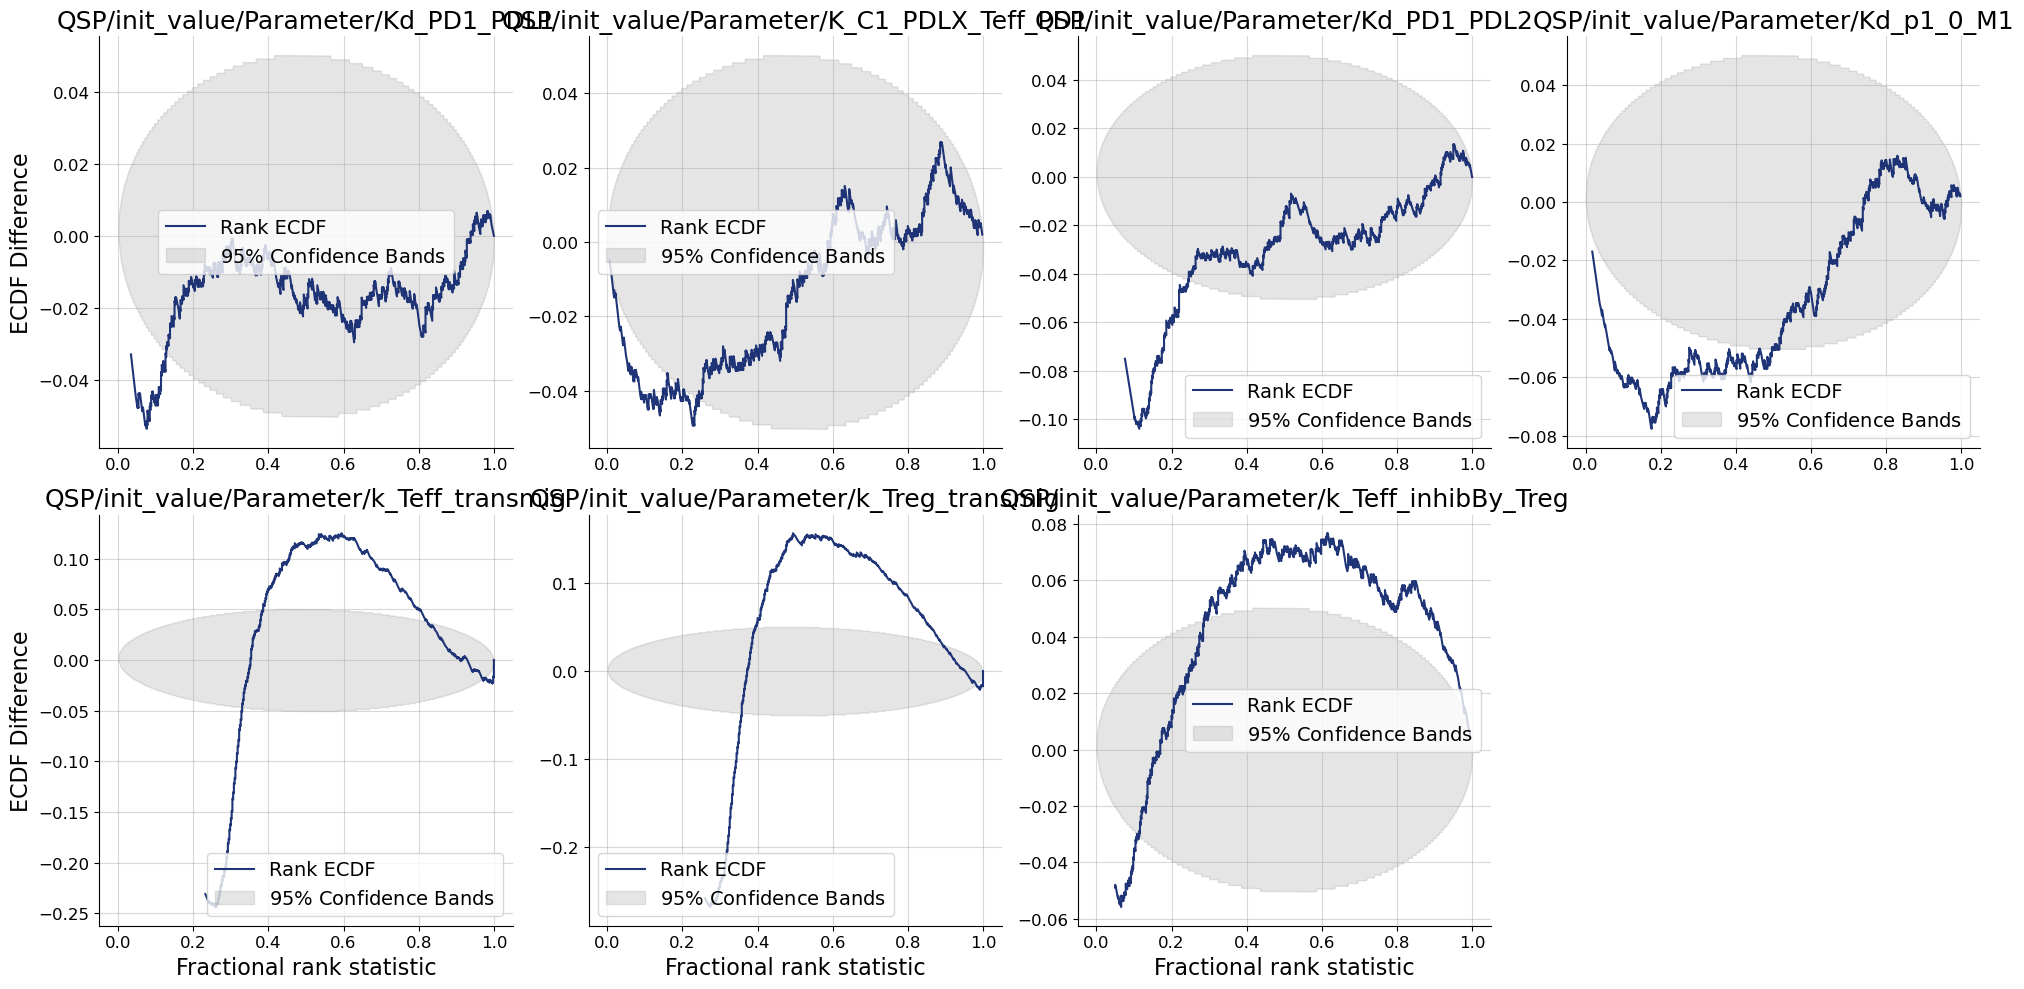

In [47]:
f = bf.diagnostics.plots.calibration_ecdf(targets.numpy(),references.numpy(),difference=True,variable_names=inference_variables)

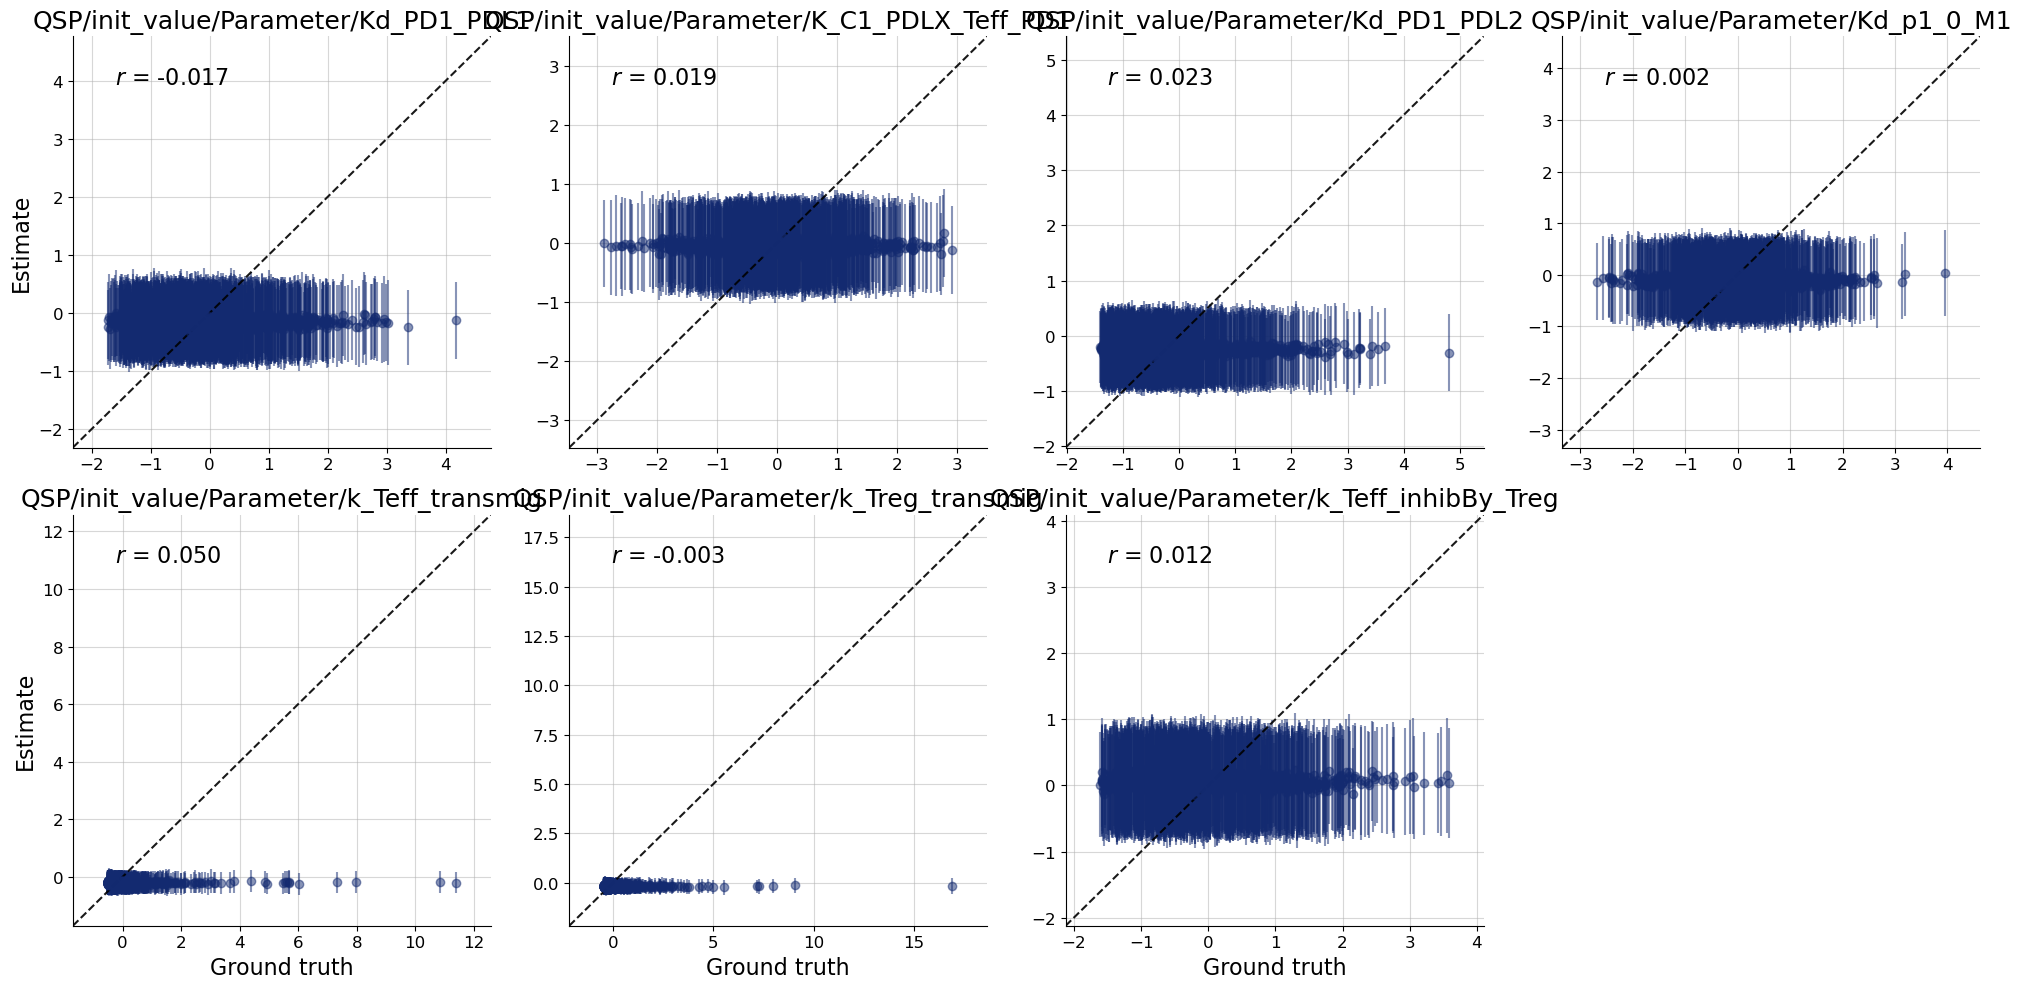

In [48]:
f = bf.diagnostics.plots.recovery(targets.numpy(),references.numpy(),variable_names=inference_variables)

In [31]:
val_dataset.params_std

tensor([9.8692e-03, 9.6212e-05, 3.3816e-01, 6.9335e-07, 1.4235e+00, 1.3702e+00,
        1.1111e+00, 1.3782e+00, 9.1590e-01, 6.7643e-01, 1.3987e+00, 5.2039e-12,
        6.5348e-12, 1.0519e+00])